# Siamese networks with contrastive loss

Demonstration of implementing Siamese networks on fashion mnist.

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.utils.vis_utils import plot_model
import pandas as pd
import tensorflow.keras.backend as K

## Loading the data
Load the data.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Normalize colors to be between (0-1).

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Set predictions class names.

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Data distribution
To see the distribution of the data we need first to sort training data by labels.

That will also help us generate positive/negative pairs.

In [ ]:
def sort_labels_by_classes(labels):
    result = []
    for i in range(len(class_names)):
        #  np.where returns the indices of elements in an input array where the given condition is satisfied
        result.append(np.where(labels == i)[0])
    return result

Sort train and test data by labels.

In [ ]:
train_classes = sort_labels_by_classes(train_labels)
test_classes = sort_labels_by_classes(test_labels)
print('Train classes:')
display(train_classes)

Plot the distributions.

In [ ]:
def plot_distributions(classes, data_type):
    # load class names and counts into dictionary for easier work with bar plot function
    distribution = {class_names[i]: len(classes[i]) for i in range(len(class_names))}
    fig = plt.figure(figsize = (10, 5))
    plt.bar(distribution.keys(), distribution.values())
    plt.grid()
    plt.title(f'{data_type} class distribution')
    plt.show()

In [ ]:
plot_distributions(train_classes, 'Train')

In [ ]:
plot_distributions(test_classes, 'Test')

## Create data pairs

Create positive/negative pairs.

Function bellow creates positive/negative pairs for even/odd indices.

In [ ]:
def create_pairs(data, labels):
    pairs_data = []
    pairs_labels = []
    class_count = len(class_names)
    # go per each of cloth class
    for i in range(len(labels)):
        # class for processing
        class_label_length = len(labels[i])
        # go for each of item in current cloth class
        for j in range(class_label_length-1):
            # get the positive pair - n and n+1 item from current label
            idx1, idx2 = labels[i][j], labels[i][j + 1]
            # save to list and set label to 1
            pairs_data.append([data[idx1], data[idx2]])
            pairs_labels.append(1.0)

            # random generate increment from 1-9 to add to current class index
            increment = random.randrange(1, class_count)
            # add increment to class index and apply modulo by class count to get random negative class label index
            negative_label_index = (i + increment) % class_count
            # take random item from other label items to create a negative pair
            negative_sample = random.choice(labels[negative_label_index])
            # save negative pair and set label to 0
            pairs_data.append([data[idx1], data[negative_sample]])
            pairs_labels.append(0.0)
    # numpy arrays are easier to work with, so type list into it
    return np.array(pairs_data), np.array(pairs_labels)

Create pairs for training.

In [ ]:
X_train, Y_train = create_pairs(train_images, train_classes)

Create pairs for test.

In [ ]:
X_test, Y_test = create_pairs(test_images, test_classes)

Plot pairs.

In [ ]:
def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [ ]:
# array index - even numbers are positive, odd numbers negative
this_pair = 20003

# print the label for this pair
print(f'Label: {Y_train[this_pair]}')

# show images at this index
show_image(X_train[this_pair][0])
show_image(X_train[this_pair][1])

## Setting up network architecture

### Backbone network for Siamese

Create backbone network that will be shared by both branches.

In [ ]:
def initialize_base_network():
    input = Input(shape=(28,28,))
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    return Model(inputs=input, outputs=x)

In [ ]:
base_network = initialize_base_network()
tf.keras.utils.plot_model(base_network, show_shapes=True)

### Similarity function - Euclidean distance

Define Euclidean distance of feature vectors as an output from network.

$d=\sqrt{(p_1 -  q_1)^{2} + (p_2 -  q_2)^{2}}$

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(tf.subtract(x, y)), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, K.epsilon()))

### Create Siamese network
Putting the network together.

In [ ]:
# create the left input and point to the base network
input_a = Input(shape=(28,28,), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer")([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

# plot model graph
tf.keras.utils.plot_model(model, show_shapes=True)

### Contrastive loss
Define contrastive loss function.

In [ ]:
# margin is a parametr settable by developer
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)    
    return contrastive_loss

## Train the model

In [ ]:
%%time
model.compile(loss=contrastive_loss_with_margin(margin=1.0), optimizer=Adam())
history = model.fit([X_train[:,0], X_train[:,1]], Y_train, batch_size=128, verbose=1, validation_data=([X_test[:,0], X_test[:,1]], Y_test), epochs=20)

### Evaluate training

In [ ]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)
    plt.grid()

In [ ]:
plot_metrics(metric_name='loss', title="Loss", ylim=0.15)

## Making predictions

We don't need the whole architecture used for training to make a predictions.

We need only a feature extractor:
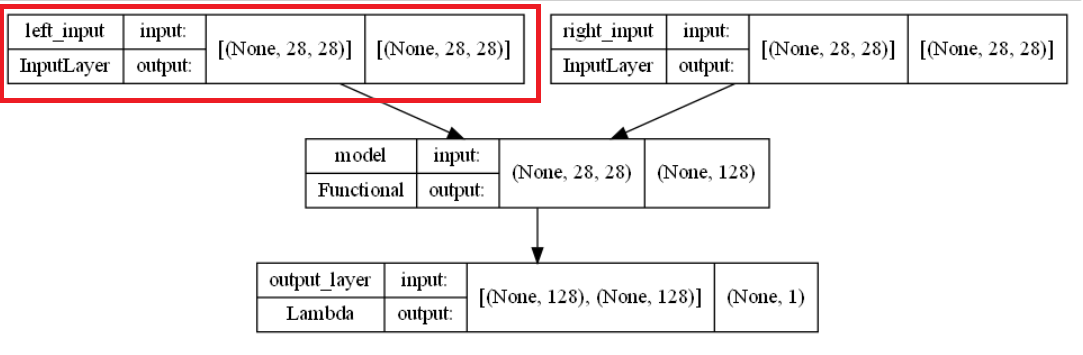

Predict feature vectors for the first image from pairs.

In [ ]:
left_image = X_test[:,0]
left_image_feature_vectors = base_network.predict(left_image)

Predict feature vectors for the second image from pairs.

In [ ]:
right_image = X_test[:,1]
right_image_feature_vectors = base_network.predict(right_image)

Get positive/negative image pairs.

In [ ]:
positive_left_image_feature_vectors = left_image_feature_vectors[0::2]
negative_left_image_feature_vectors = left_image_feature_vectors[1::2]

positive_right_image_feature_vectors = right_image_feature_vectors[0::2]
negative_right_image_feature_vectors = right_image_feature_vectors[1::2]

### Positive pairs distances

In [ ]:
positive_distances = euclidean_distance((positive_left_image_feature_vectors, positive_right_image_feature_vectors)).numpy().flatten()
pd.Series(positive_distances).describe()

### Negative pairs distances

In [ ]:
negative_distances = euclidean_distance((negative_left_image_feature_vectors, negative_right_image_feature_vectors)).numpy().flatten()
pd.Series(negative_distances).describe()

Visualize using box plots.

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1, 1])
ax.boxplot([positive_distances, negative_distances])
plt.xticks([1, 2], ['Positive', 'Negative'])
ax.grid()
plt.show()

## Get model accuracy

We need to decide value of threshold for classifying "same" and "different".

In [ ]:
def compute_accuracy(y_true, y_pred):
    # 1 for the same - distance is smaller than 0.5, 0 for the different
    pred = y_pred.flatten() < 0.5
    return np.mean(pred == y_true)

In [ ]:
y_pred_test = model.predict([X_test[:,0], X_test[:,1]])
test_accuracy = compute_accuracy(Y_test, y_pred_test)
print(f'Test accuracy: {test_accuracy*100:.2f}%')

## Plot predictions

Take random 10 pairs from test set and display distances.

In [ ]:
def display_images(left, right, predictions, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    # create 1 wide image from 10 different input images
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: 
            t.set_color('red')
    plt.grid(None)
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

In [ ]:
y_pred_test = np.squeeze(y_pred_test)
indexes = np.random.choice(len(y_pred_test), size=10)
display_images(X_test[:, 0][indexes], X_test[:, 1][indexes], y_pred_test[indexes], 'Clothes and their dissimilarity', 10)

## Inference using feature vectors

You can have precomputed values and predict feature vectors only for images neural network has never seen before.

In [ ]:
index = 120

In [ ]:
fv_1 = base_network.predict(np.expand_dims(X_test[index, 0], axis=0))
print(fv_1)

In [ ]:
fv_2 = base_network.predict(np.expand_dims(X_test[index, 1], axis=0))
print(fv_2)

We can use precomputed vectors and just calculate the distance and compare it with the threshold.

In [ ]:
euclidean_distance((fv_1, fv_2))

The same result as using whole model for predicting distance.

In [ ]:
model.predict([np.expand_dims(X_test[index, 0], axis=0), np.expand_dims(X_test[index, 1], axis=0)])